In [1]:
import requests
import json

## NOTE: These examples won't work because the environments have been disabled in the API
## but you can see the plots in the ./example folder
# task_path = "example/other_example.json"

task_path = r"/Users/khomeshkumarsahu/Desktop/Amazon_agentic/amazon-tau-bench-tasks/week_6/nithin_pod/khomesh02-finance-5-medium-1754637300/task.json"

with open(task_path, 'r') as file:
    task_json = json.load(file)

API_BASE_URL= "https://tau-bench.turing.com/"

response = requests.post(
    f"{API_BASE_URL}/task_verification",
    json=task_json,
    headers={"Content-Type": "application/json"}
)
response.status_code

200

In [3]:
response.json()

{'success': True,
 'plot_base64': 'iVBORw0KGgoAAAANSUhEUgAAEkEAAAvJCAYAAACIiXYAAAAABmJLR0QA/wD/AP+gvaeTAAAgAElEQVR4nOzca5DV9X3H8e/ZC3vjliLGXVSEOARZoygiIqggUYIaUIMJkwFEmZpmGtMHNePk8iAXM23j1LSxDlEnF6MjtdhQolZqUFGLGvEKRkCrIaBxYQmwruwCy+72mdMnPeeAe/6/s7uv1wyP/t//n88TeHTmnevt7e0NAAAAAAAAAAAAAAAAAAAAAACAbLVWpF4AAAAAAAAAAAAAAAAAAAAAAAAMTiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAAABAEiJIAAAAAAAAAAAAAAAAAAAAA

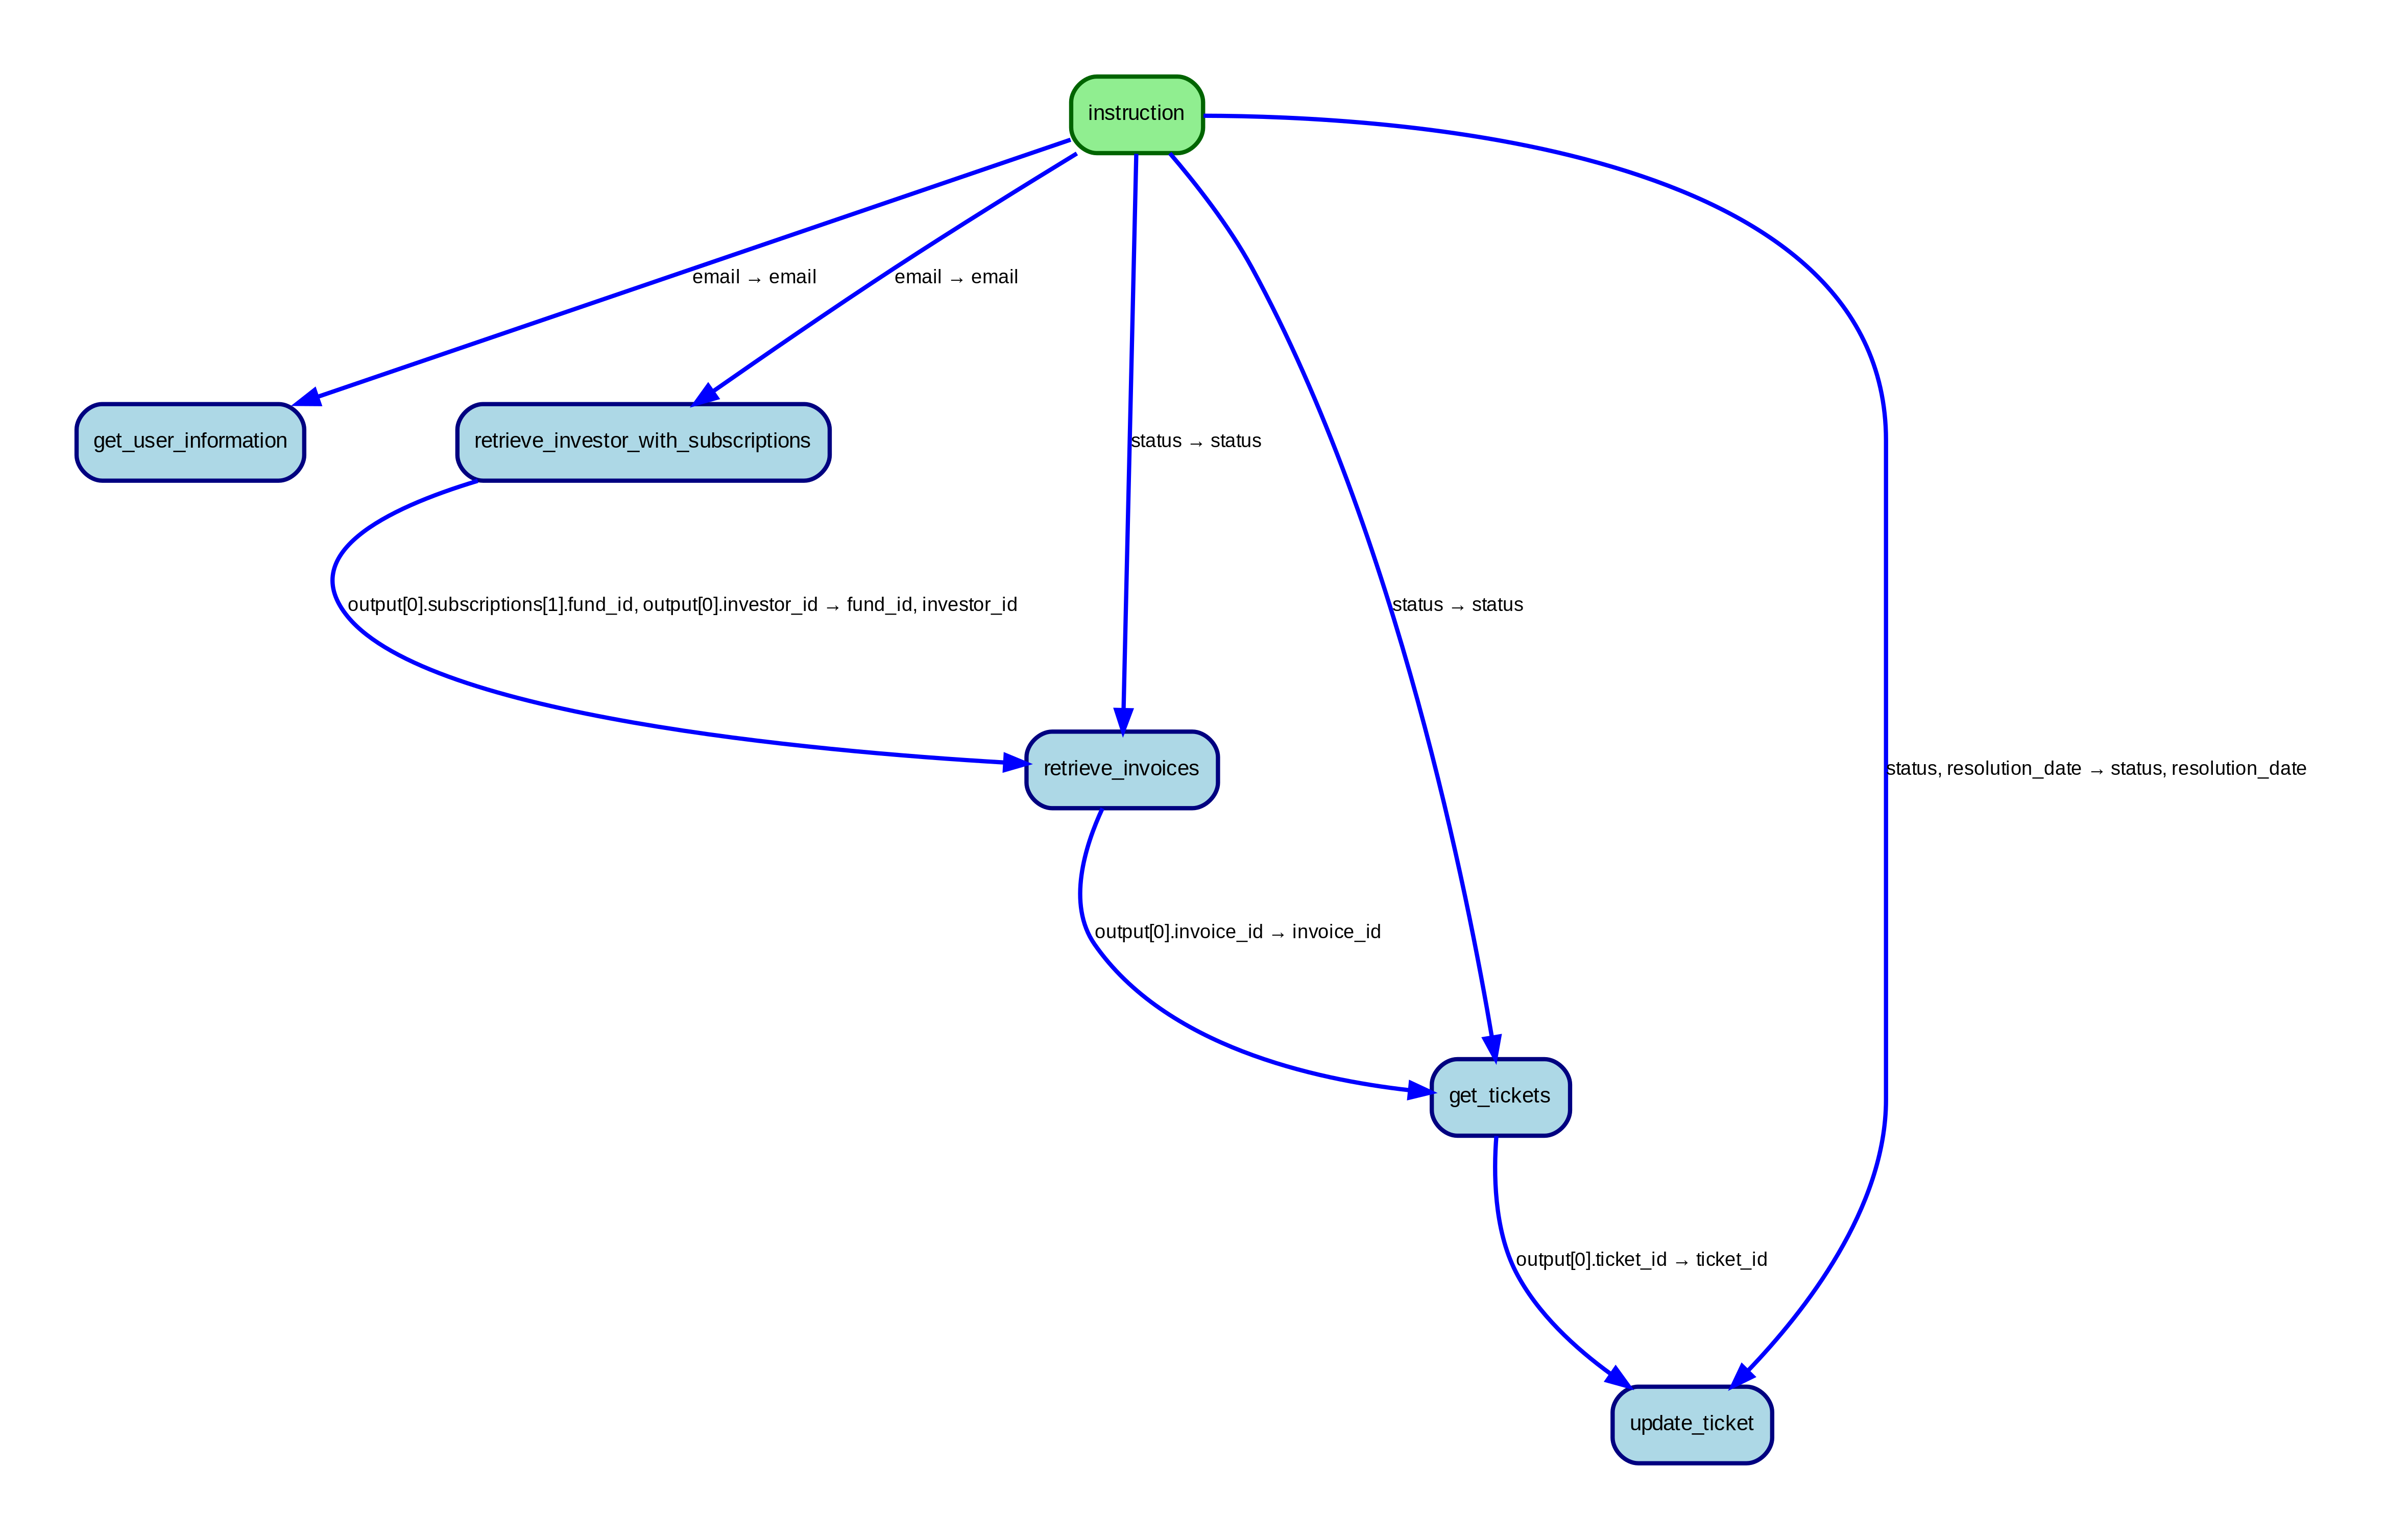

In [4]:
from IPython.display import Image
from IPython.display import display
import base64

plot_base64 = response.json()['plot_base64']
plot_image = base64.b64decode(plot_base64)

display(Image(data=plot_image))